In [1]:
### Load the required libraries

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import requests
import re

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
%%time
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from tqdm import tqdm, tqdm_notebook
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer

Wall time: 1.2 s


In [3]:
### To read the useful csv file into DataFrame

df = pd.read_csv(r"data/Tweets.csv")

In [4]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [6]:
df.shape

(14640, 15)

In [7]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [8]:
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [9]:
mode_negative_reason = df.groupby('airline_sentiment')['negativereason'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()
mode_negative_reason_confidence = df.groupby('airline_sentiment')['negativereason_confidence'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()
mode_airline_sentiment_gold = df.groupby('airline_sentiment')['airline_sentiment_gold'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()
mode_negative_reason_gold = df.groupby('airline_sentiment')['negativereason_gold'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()
mode_tweet_coord = df.groupby('airline_sentiment')['tweet_coord'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()
mode_tweet_location = df.groupby('airline_sentiment')['tweet_location'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()
mode_user_timezone = df.groupby('airline_sentiment')['user_timezone'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()

In [10]:
mode_negative_reason

,airline_sentiment,negativereason
0,negative,Customer Service Issue
1,neutral,None
2,positive,None


In [11]:
mode_negative_reason_confidence

,airline_sentiment,negativereason_confidence
0,negative,1.0
1,neutral,0.0
2,positive,0.0


In [12]:
mode_airline_sentiment_gold

,airline_sentiment,airline_sentiment_gold
0,negative,negative
1,neutral,neutral
2,positive,positive


In [13]:
mode_negative_reason_gold

,airline_sentiment,negativereason_gold
0,negative,Customer Service Issue
1,neutral,None
2,positive,None


In [14]:
mode_tweet_coord

,airline_sentiment,tweet_coord
0,negative,"[0.0, 0.0]"
1,neutral,"[0.0, 0.0]"
2,positive,"[0.0, 0.0]"


In [15]:
mode_tweet_location

,airline_sentiment,tweet_location
0,negative,"Washington, DC"
1,neutral,USA
2,positive,"New York, NY"


In [16]:
mode_user_timezone

,airline_sentiment,user_timezone
0,negative,Eastern Time (US & Canada)
1,neutral,Eastern Time (US & Canada)
2,positive,Eastern Time (US & Canada)


In [17]:
dfs = [mode_negative_reason, mode_negative_reason_confidence, mode_airline_sentiment_gold, mode_negative_reason_gold, mode_tweet_coord, mode_tweet_location, mode_user_timezone]

In [18]:
from functools import reduce
new = reduce(lambda  left,right: pd.merge(left,right,on=['airline_sentiment'], how='outer'), dfs)

In [19]:
new

,airline_sentiment,negativereason,negativereason_confidence,airline_sentiment_gold,negativereason_gold,tweet_coord,tweet_location,user_timezone
0,negative,Customer Service Issue,1.0,negative,Customer Service Issue,"[0.0, 0.0]","Washington, DC",Eastern Time (US & Canada)
1,neutral,None,0.0,neutral,None,"[0.0, 0.0]",USA,Eastern Time (US & Canada)
2,positive,None,0.0,positive,None,"[0.0, 0.0]","New York, NY",Eastern Time (US & Canada)


In [20]:
df = df.set_index('airline_sentiment')
new = new.set_index('airline_sentiment')

In [21]:
df1 = df.combine_first(new).reset_index()

In [22]:
df1

,airline_sentiment,airline,airline_sentiment_confidence,airline_sentiment_gold,name,negativereason,negativereason_confidence,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,negative,Virgin America,1.0000,negative,jnardino,Bad Flight,0.7033,Customer Service Issue,0,@VirginAmerica it's really aggressive to blast...,"[0.0, 0.0]",2015-02-24 11:15:36 -0800,570301031407624196,"Washington, DC",Pacific Time (US & Canada)
1,negative,Virgin America,1.0000,negative,jnardino,Can't Tell,1.0000,Customer Service Issue,0,@VirginAmerica and it's a really big bad thing...,"[0.0, 0.0]",2015-02-24 11:14:45 -0800,570300817074462722,"Washington, DC",Pacific Time (US & Canada)
2,negative,Virgin America,1.0000,negative,jnardino,Can't Tell,0.6842,Customer Service Issue,0,@VirginAmerica seriously would pay $30 a fligh...,"[0.0, 0.0]",2015-02-24 11:14:33 -0800,570300767074181121,"Washington, DC",Pacific Time (US & Canada)
3,negative,Virgin America,0.6842,negative,smartwatermelon,Late Flight,0.3684,Customer Service Issue,0,@VirginAmerica SFO-PDX schedule is still MIA.,"[0.0, 0.0]",2015-02-24 10:01:50 -0800,570282469121007616,"palo alto, ca",Pacific Time (US & Canada)
4,negative,Virgin America,1.0000,negative,heatherovieda,Bad Flight,1.0000,Customer Service Issue,0,@VirginAmerica I flew from NYC to SFO last we...,"[0.0, 0.0]",2015-02-24 09:39:46 -0800,570276917301137409,this place called NYC,Eastern Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,positive,American,0.6274,positive,Flora_Lola_NYC,None,0.0000,None,0,@AmericanAir Love the new planes for the JFK-L...,"[0.0, 0.0]",2015-02-22 12:10:16 -0800,569590013278756865,"New York, NY",Eastern Time (US & Canada)
14636,positive,American,1.0000,positive,DrCaseyJRudkin,None,0.0000,None,0,@AmericanAir Flight 236 was great. Fantastic c...,"[40.64946781, -73.76624703]",2015-02-22 12:08:48 -0800,569589643487928321,East Coast,Eastern Time (US & Canada)
14637,positive,American,1.0000,positive,jlhalldc,None,0.0000,None,0,Thank you. “@AmericanAir: @jlhalldc Customer R...,"[0.0, 0.0]",2015-02-22 12:04:51 -0800,569588651925098496,"Washington, DC",Eastern Time (US & Canada)
14638,positive,American,1.0000,positive,Laurelinesblog,None,0.0000,None,0,@AmericanAir Thanks! He is.,"[0.0, 0.0]",2015-02-22 12:04:09 -0800,569588473050611712,"Chapel Hill, NC",Eastern Time (US & Canada)


In [23]:
# Function to classify reviews as positive or negative based on ratings
def classify_review(airline_sentiment):
    if airline_sentiment == 'negative':
        return 0
    else:
        return 1
    
df1['sentiment'] = df1['airline_sentiment'].apply(classify_review)

In [24]:
df1

,airline_sentiment,airline,airline_sentiment_confidence,airline_sentiment_gold,name,negativereason,negativereason_confidence,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone,sentiment
0,negative,Virgin America,1.0000,negative,jnardino,Bad Flight,0.7033,Customer Service Issue,0,@VirginAmerica it's really aggressive to blast...,"[0.0, 0.0]",2015-02-24 11:15:36 -0800,570301031407624196,"Washington, DC",Pacific Time (US & Canada),0
1,negative,Virgin America,1.0000,negative,jnardino,Can't Tell,1.0000,Customer Service Issue,0,@VirginAmerica and it's a really big bad thing...,"[0.0, 0.0]",2015-02-24 11:14:45 -0800,570300817074462722,"Washington, DC",Pacific Time (US & Canada),0
2,negative,Virgin America,1.0000,negative,jnardino,Can't Tell,0.6842,Customer Service Issue,0,@VirginAmerica seriously would pay $30 a fligh...,"[0.0, 0.0]",2015-02-24 11:14:33 -0800,570300767074181121,"Washington, DC",Pacific Time (US & Canada),0
3,negative,Virgin America,0.6842,negative,smartwatermelon,Late Flight,0.3684,Customer Service Issue,0,@VirginAmerica SFO-PDX schedule is still MIA.,"[0.0, 0.0]",2015-02-24 10:01:50 -0800,570282469121007616,"palo alto, ca",Pacific Time (US & Canada),0
4,negative,Virgin America,1.0000,negative,heatherovieda,Bad Flight,1.0000,Customer Service Issue,0,@VirginAmerica I flew from NYC to SFO last we...,"[0.0, 0.0]",2015-02-24 09:39:46 -0800,570276917301137409,this place called NYC,Eastern Time (US & Canada),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,positive,American,0.6274,positive,Flora_Lola_NYC,None,0.0000,None,0,@AmericanAir Love the new planes for the JFK-L...,"[0.0, 0.0]",2015-02-22 12:10:16 -0800,569590013278756865,"New York, NY",Eastern Time (US & Canada),1
14636,positive,American,1.0000,positive,DrCaseyJRudkin,None,0.0000,None,0,@AmericanAir Flight 236 was great. Fantastic c...,"[40.64946781, -73.76624703]",2015-02-22 12:08:48 -0800,569589643487928321,East Coast,Eastern Time (US & Canada),1
14637,positive,American,1.0000,positive,jlhalldc,None,0.0000,None,0,Thank you. “@AmericanAir: @jlhalldc Customer R...,"[0.0, 0.0]",2015-02-22 12:04:51 -0800,569588651925098496,"Washington, DC",Eastern Time (US & Canada),1
14638,positive,American,1.0000,positive,Laurelinesblog,None,0.0000,None,0,@AmericanAir Thanks! He is.,"[0.0, 0.0]",2015-02-22 12:04:09 -0800,569588473050611712,"Chapel Hill, NC",Eastern Time (US & Canada),1


In [25]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   airline_sentiment             14640 non-null  object 
 1   airline                       14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   airline_sentiment_gold        14640 non-null  object 
 4   name                          14640 non-null  object 
 5   negativereason                9178 non-null   object 
 6   negativereason_confidence     14640 non-null  float64
 7   negativereason_gold           9178 non-null   object 
 8   retweet_count                 14640 non-null  int64  
 9   text                          14640 non-null  object 
 10  tweet_coord                   14640 non-null  object 
 11  tweet_created                 14640 non-null  object 
 12  tweet_id                      14640 non-null  int64  
 13  t

In [26]:
df1.shape

(14640, 16)

In [27]:
df1['sentiment'].value_counts()

0    9178
1    5462
Name: sentiment, dtype: int64

In [28]:
df1['sentiment'].value_counts(normalize=True)

0    0.626913
1    0.373087
Name: sentiment, dtype: float64

<AxesSubplot:xlabel='sentiment', ylabel='count'>

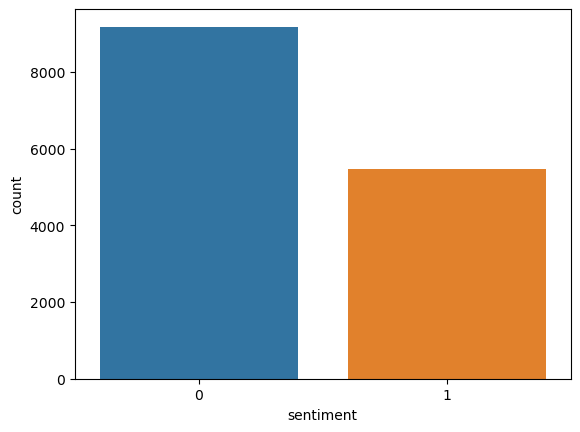

In [29]:
sns.countplot(x='sentiment', data=df1)

<AxesSubplot:ylabel='sentiment'>

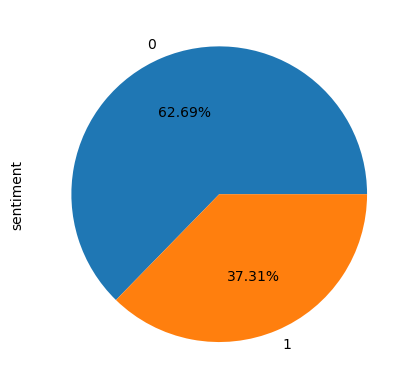

In [30]:
df1['sentiment'].value_counts().plot.pie(autopct='%.2f%%')

In [31]:
df1.columns

Index(['airline_sentiment', 'airline', 'airline_sentiment_confidence',
       'airline_sentiment_gold', 'name', 'negativereason',
       'negativereason_confidence', 'negativereason_gold', 'retweet_count',
       'text', 'tweet_coord', 'tweet_created', 'tweet_id', 'tweet_location',
       'user_timezone', 'sentiment'],
      dtype='object')

In [32]:
tqdm.pandas()

In [33]:
## initialise the inbuilt Stemmer
stemmer = PorterStemmer()

In [34]:
## We can also use Lemmatizer instead of Stemmer
lemmatizer = WordNetLemmatizer()

In [35]:
def preprocess(raw_text, flag):
    # Removing special characters and digits
    sentence = re.sub("[^a-zA-Z]", " ", raw_text)
    
    # change sentence to lower case
    sentence = sentence.lower()

    # tokenize into words
    tokens = sentence.split()
    
    # remove stop words                
    clean_tokens = [t for t in tokens if not t in stopwords.words("english")]
    
    # Stemming/Lemmatization
    if(flag == 'stem'):
        clean_tokens = [stemmer.stem(word) for word in clean_tokens]
    else:
        clean_tokens = [lemmatizer.lemmatize(word) for word in clean_tokens]
    
    return pd.Series([" ".join(clean_tokens)])

In [36]:
df2 = df1['text'].progress_apply(lambda x: preprocess(x, 'stem'))

df2.head()

100%|████████████████████████████████████████████████████████████████████████████| 14640/14640 [04:05<00:00, 59.51it/s]


,0
0,virginamerica realli aggress blast obnoxi ente...
1,virginamerica realli big bad thing
2,virginamerica serious would pay flight seat pl...
3,virginamerica sfo pdx schedul still mia
4,virginamerica flew nyc sfo last week fulli sit...


In [37]:
df2.columns = ['clean_tweet_stem']

df2.head()

,clean_tweet_stem
0,virginamerica realli aggress blast obnoxi ente...
1,virginamerica realli big bad thing
2,virginamerica serious would pay flight seat pl...
3,virginamerica sfo pdx schedul still mia
4,virginamerica flew nyc sfo last week fulli sit...


In [38]:
df1 = pd.concat([df1, df2], axis=1)

df1.head()

,airline_sentiment,airline,airline_sentiment_confidence,airline_sentiment_gold,name,negativereason,negativereason_confidence,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone,sentiment,clean_tweet_stem
0,negative,Virgin America,1.0000,negative,jnardino,Bad Flight,0.7033,Customer Service Issue,0,@VirginAmerica it's really aggressive to blast...,"[0.0, 0.0]",2015-02-24 11:15:36 -0800,570301031407624196,"Washington, DC",Pacific Time (US & Canada),0,virginamerica realli aggress blast obnoxi ente...
1,negative,Virgin America,1.0000,negative,jnardino,Can't Tell,1.0000,Customer Service Issue,0,@VirginAmerica and it's a really big bad thing...,"[0.0, 0.0]",2015-02-24 11:14:45 -0800,570300817074462722,"Washington, DC",Pacific Time (US & Canada),0,virginamerica realli big bad thing
2,negative,Virgin America,1.0000,negative,jnardino,Can't Tell,0.6842,Customer Service Issue,0,@VirginAmerica seriously would pay $30 a fligh...,"[0.0, 0.0]",2015-02-24 11:14:33 -0800,570300767074181121,"Washington, DC",Pacific Time (US & Canada),0,virginamerica serious would pay flight seat pl...
3,negative,Virgin America,0.6842,negative,smartwatermelon,Late Flight,0.3684,Customer Service Issue,0,@VirginAmerica SFO-PDX schedule is still MIA.,"[0.0, 0.0]",2015-02-24 10:01:50 -0800,570282469121007616,"palo alto, ca",Pacific Time (US & Canada),0,virginamerica sfo pdx schedul still mia
4,negative,Virgin America,1.0000,negative,heatherovieda,Bad Flight,1.0000,Customer Service Issue,0,@VirginAmerica I flew from NYC to SFO last we...,"[0.0, 0.0]",2015-02-24 09:39:46 -0800,570276917301137409,this place called NYC,Eastern Time (US & Canada),0,virginamerica flew nyc sfo last week fulli sit...


In [39]:
df2 = df1['text'].progress_apply(lambda x: preprocess(x, 'lemma'))

df2.head()

100%|████████████████████████████████████████████████████████████████████████████| 14640/14640 [03:22<00:00, 72.42it/s]


,0
0,virginamerica really aggressive blast obnoxiou...
1,virginamerica really big bad thing
2,virginamerica seriously would pay flight seat ...
3,virginamerica sfo pdx schedule still mia
4,virginamerica flew nyc sfo last week fully sit...


In [40]:
df2.columns = ['clean_tweet_lemma']

df2.head()

,clean_tweet_lemma
0,virginamerica really aggressive blast obnoxiou...
1,virginamerica really big bad thing
2,virginamerica seriously would pay flight seat ...
3,virginamerica sfo pdx schedule still mia
4,virginamerica flew nyc sfo last week fully sit...


In [41]:
df1 = pd.concat([df1, df2], axis=1)

df1.head()

,airline_sentiment,airline,airline_sentiment_confidence,airline_sentiment_gold,name,negativereason,negativereason_confidence,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone,sentiment,clean_tweet_stem,clean_tweet_lemma
0,negative,Virgin America,1.0000,negative,jnardino,Bad Flight,0.7033,Customer Service Issue,0,@VirginAmerica it's really aggressive to blast...,"[0.0, 0.0]",2015-02-24 11:15:36 -0800,570301031407624196,"Washington, DC",Pacific Time (US & Canada),0,virginamerica realli aggress blast obnoxi ente...,virginamerica really aggressive blast obnoxiou...
1,negative,Virgin America,1.0000,negative,jnardino,Can't Tell,1.0000,Customer Service Issue,0,@VirginAmerica and it's a really big bad thing...,"[0.0, 0.0]",2015-02-24 11:14:45 -0800,570300817074462722,"Washington, DC",Pacific Time (US & Canada),0,virginamerica realli big bad thing,virginamerica really big bad thing
2,negative,Virgin America,1.0000,negative,jnardino,Can't Tell,0.6842,Customer Service Issue,0,@VirginAmerica seriously would pay $30 a fligh...,"[0.0, 0.0]",2015-02-24 11:14:33 -0800,570300767074181121,"Washington, DC",Pacific Time (US & Canada),0,virginamerica serious would pay flight seat pl...,virginamerica seriously would pay flight seat ...
3,negative,Virgin America,0.6842,negative,smartwatermelon,Late Flight,0.3684,Customer Service Issue,0,@VirginAmerica SFO-PDX schedule is still MIA.,"[0.0, 0.0]",2015-02-24 10:01:50 -0800,570282469121007616,"palo alto, ca",Pacific Time (US & Canada),0,virginamerica sfo pdx schedul still mia,virginamerica sfo pdx schedule still mia
4,negative,Virgin America,1.0000,negative,heatherovieda,Bad Flight,1.0000,Customer Service Issue,0,@VirginAmerica I flew from NYC to SFO last we...,"[0.0, 0.0]",2015-02-24 09:39:46 -0800,570276917301137409,this place called NYC,Eastern Time (US & Canada),0,virginamerica flew nyc sfo last week fulli sit...,virginamerica flew nyc sfo last week fully sit...


In [42]:
# Splitting into train and test

from sklearn.model_selection import train_test_split

train, test = train_test_split(df1, test_size=0.2, random_state=42)

In [43]:
train.head()

,airline_sentiment,airline,airline_sentiment_confidence,airline_sentiment_gold,name,negativereason,negativereason_confidence,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone,sentiment,clean_tweet_stem,clean_tweet_lemma
750,negative,United,1.0000,negative,bmalones44,Bad Flight,0.3451,Customer Service Issue,1,@united - 75% of a plane's passengers boarding...,"[0.0, 0.0]",2015-02-23 03:43:39 -0800,569824906638073856,P.R.O.B.,Quito,0,unit plane passeng board premier group might i...,united plane passenger boarding premier group ...
6875,negative,US Airways,1.0000,negative,Twinscream1,Customer Service Issue,1.0000,Customer Service Issue,0,@USAirways I have sent letter after letter and...,"[0.0, 0.0]",2015-02-18 11:18:40 -0800,568127477555441664,"Washington, DC",Eastern Time (US & Canada),0,usairway sent letter letter get back noth form...,usairways sent letter letter get back nothing ...
7598,negative,American,1.0000,negative,danilo23donna,longlines,0.3598,Customer Service Issue,0,@AmericanAir its not weather thats why i said ...,"[0.0, 0.0]",2015-02-23 23:55:21 -0800,570129843594997760,"Washington, DC",Eastern Time (US & Canada),0,americanair weather that said peopl receiv hot...,americanair weather thats said people received...
14124,positive,US Airways,0.3502,positive,MattClement,None,0.0000,None,0,@USAirways Oh well. I'll get to Cancun eventua...,"[0.0, 0.0]",2015-02-21 19:05:57 -0800,569332237138841600,"Troy, NY",Eastern Time (US & Canada),1,usairway oh well get cancun eventu,usairways oh well get cancun eventually
6187,negative,US Airways,1.0000,negative,POnions,Customer Service Issue,0.3683,Customer Service Issue,0,@USAirways looking forward to waiting on hold ...,"[0.0, 0.0]",2015-02-21 13:09:04 -0800,569242425530712064,"CT, USA",Central Time (US & Canada),0,usairway look forward wait hold hr reschedul f...,usairways looking forward waiting hold hr resc...


In [44]:
train.shape

(11712, 18)

In [45]:
Positive_df = train.loc[train['sentiment']==1, :]

Positive_df.head()

,airline_sentiment,airline,airline_sentiment_confidence,airline_sentiment_gold,name,negativereason,negativereason_confidence,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone,sentiment,clean_tweet_stem,clean_tweet_lemma
14124,positive,US Airways,0.3502,positive,MattClement,None,0.0,None,0,@USAirways Oh well. I'll get to Cancun eventua...,"[0.0, 0.0]",2015-02-21 19:05:57 -0800,569332237138841600,"Troy, NY",Eastern Time (US & Canada),1,usairway oh well get cancun eventu,usairways oh well get cancun eventually
13188,positive,Southwest,1.0000,positive,erin_christman,None,0.0,None,2,@SouthwestAir THANK YOU SO MUCH FOR ACCESS TO ...,"[0.0, 0.0]",2015-02-20 14:07:16 -0800,568894680881963008,TX | CA,Central Time (US & Canada),1,southwestair thank much access destinationdrag...,southwestair thank much access destinationdrag...
13036,positive,Southwest,0.6549,positive,SarahCalhoon,None,0.0,None,0,@SouthwestAir TY for your consideration!,"[40.76352814, -111.89191896]",2015-02-22 20:10:53 -0800,569710964712411136,Minneapolis,Central Time (US & Canada),1,southwestair ty consider,southwestair ty consideration
9876,neutral,United,0.3748,neutral,skilleahy,None,0.0,None,0,@united @staralliance good. Maybe that will m...,"[0.0, 0.0]",2015-02-19 02:27:00 -0800,568356065428918272,USA,Sarajevo,1,unit staralli good mayb make lose medallion pr...,united staralliance good maybe make losing med...
10216,neutral,Southwest,0.6592,neutral,ae4mcae,None,0.0,None,0,@SouthwestAir Flying South by Southwest from S...,"[0.0, 0.0]",2015-02-22 15:56:09 -0800,569646857632096256,"Fremont, CA",Pacific Time (US & Canada),1,southwestair fli south southwest sjc sna tiday...,southwestair flying south southwest sjc sna ti...


In [46]:
words = ' '.join(Positive_df['clean_tweet_lemma'])

print(words[:100])

usairways oh well get cancun eventually southwestair thank much access destinationdragons tonight th


In [47]:
Positive_df = train.loc[train['sentiment']==1, :]

words = ' '.join(Positive_df['clean_tweet_lemma'])

cleaned_word = " ".join([word for word in words.split() 
                        if 'subject' not in word])

In [48]:
Positive_wordcloud = WordCloud(stopwords=stopwords.words("english"),
                      background_color='black',
                      width=1600,
                      height=800
                     ).generate(cleaned_word)

<Figure size 3000x2000 with 0 Axes>

(-0.5, 1599.5, 799.5, -0.5)

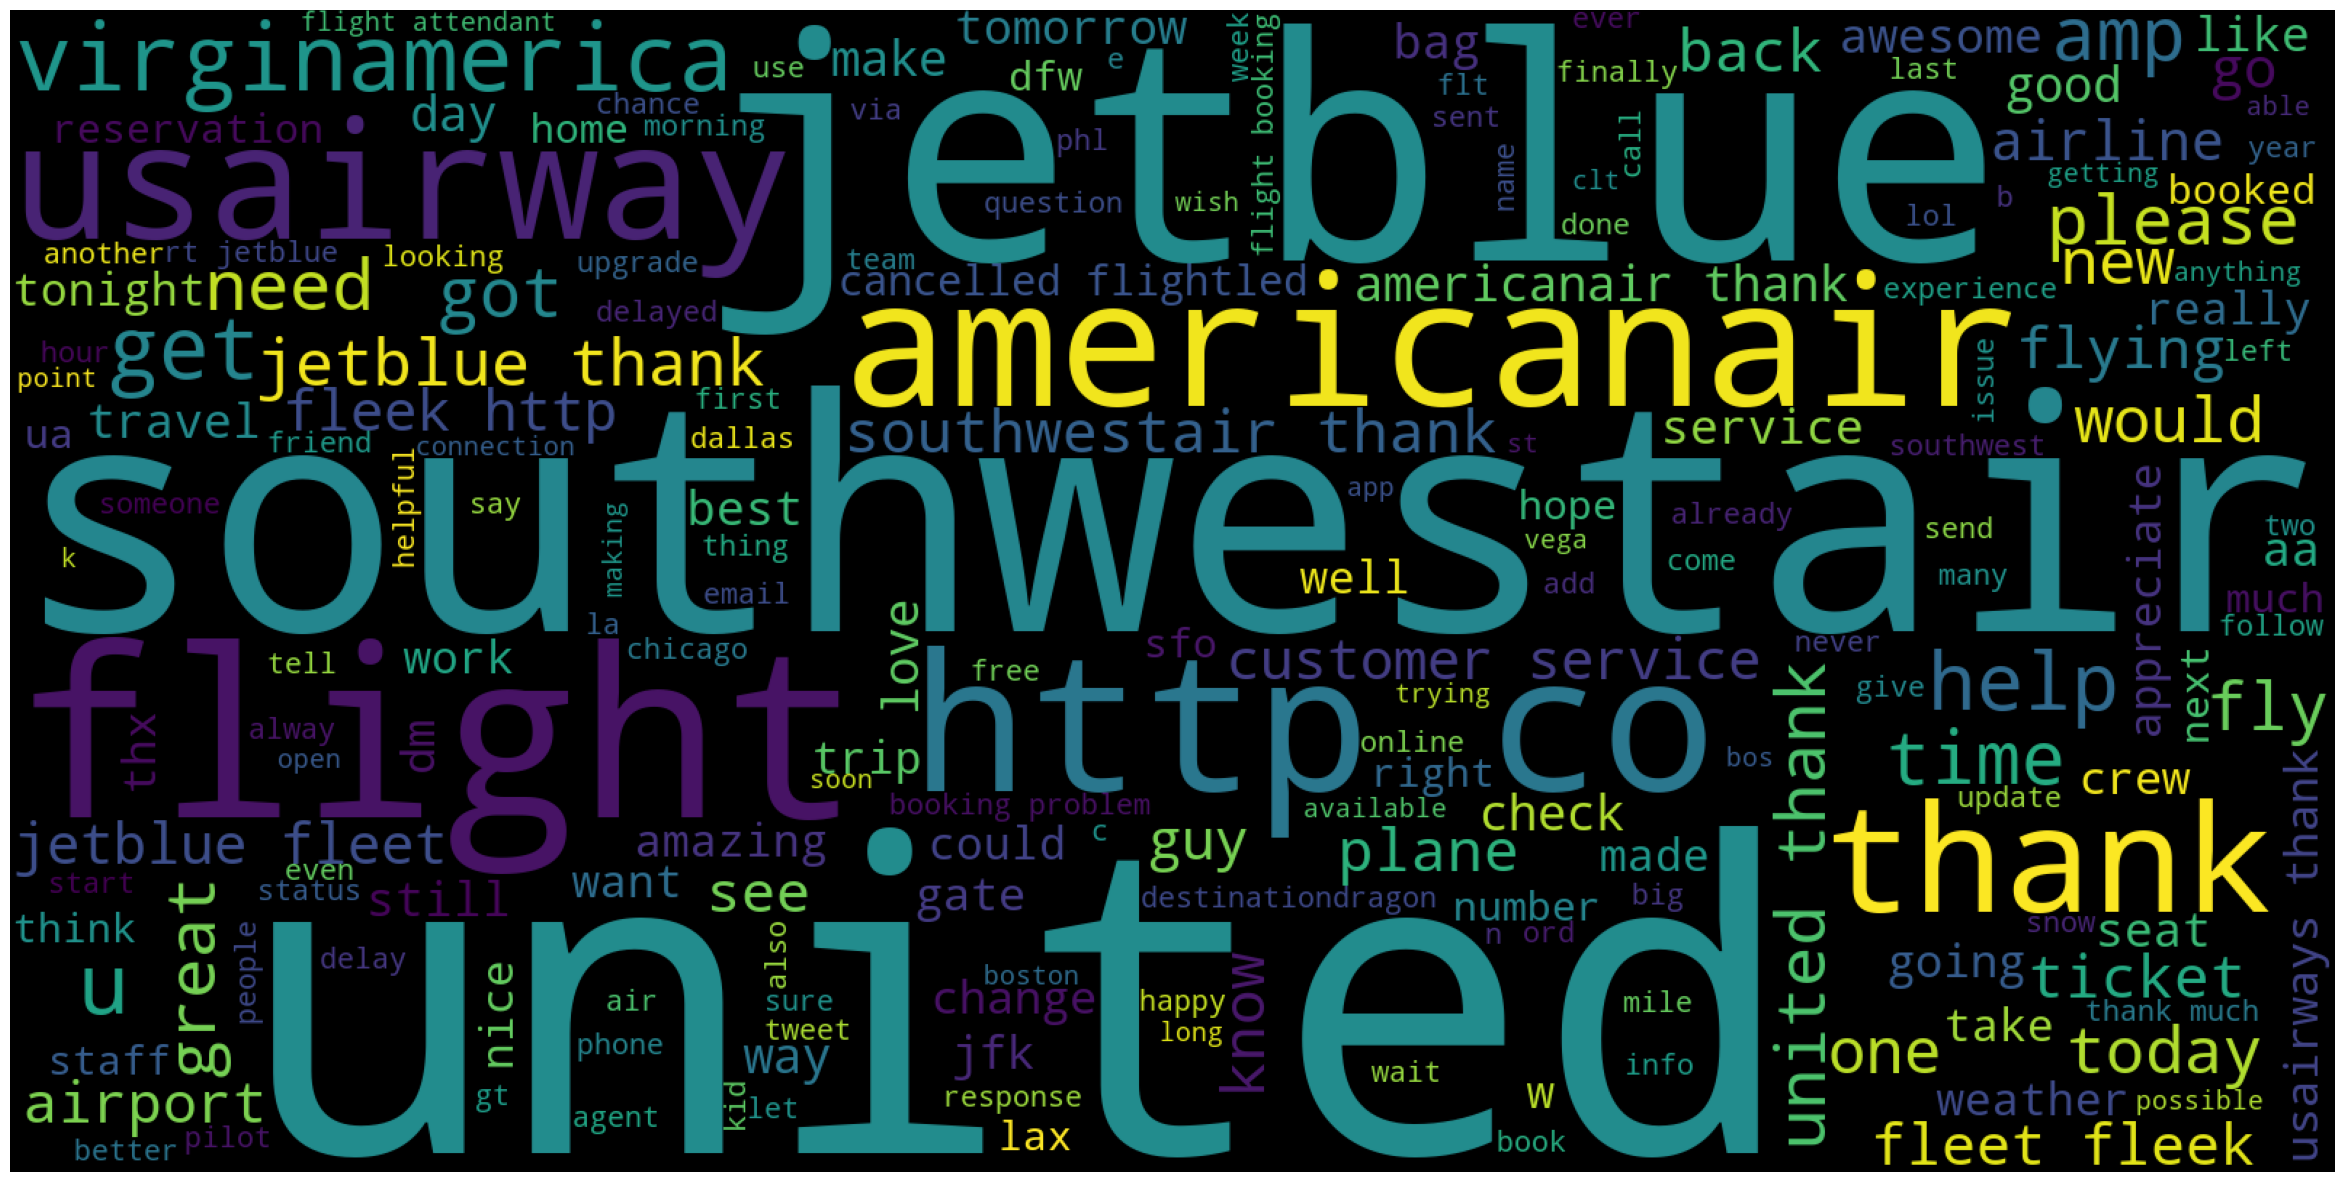

In [49]:
plt.figure(1,figsize=(30,20))
plt.imshow(Positive_wordcloud)
plt.axis('off')
plt.show()

In [50]:
Negative_df = train.loc[train['sentiment']==0, :]

words = ' '.join(Negative_df['clean_tweet_lemma'])

cleaned_word = " ".join([word for word in words.split() 
                        if 'subject' not in word])

In [51]:
Negative_wordcloud = WordCloud(stopwords=stopwords.words("english"),
                      background_color='black',
                      width=1600,
                      height=800
                     ).generate(cleaned_word)

<Figure size 3000x2000 with 0 Axes>

(-0.5, 1599.5, 799.5, -0.5)

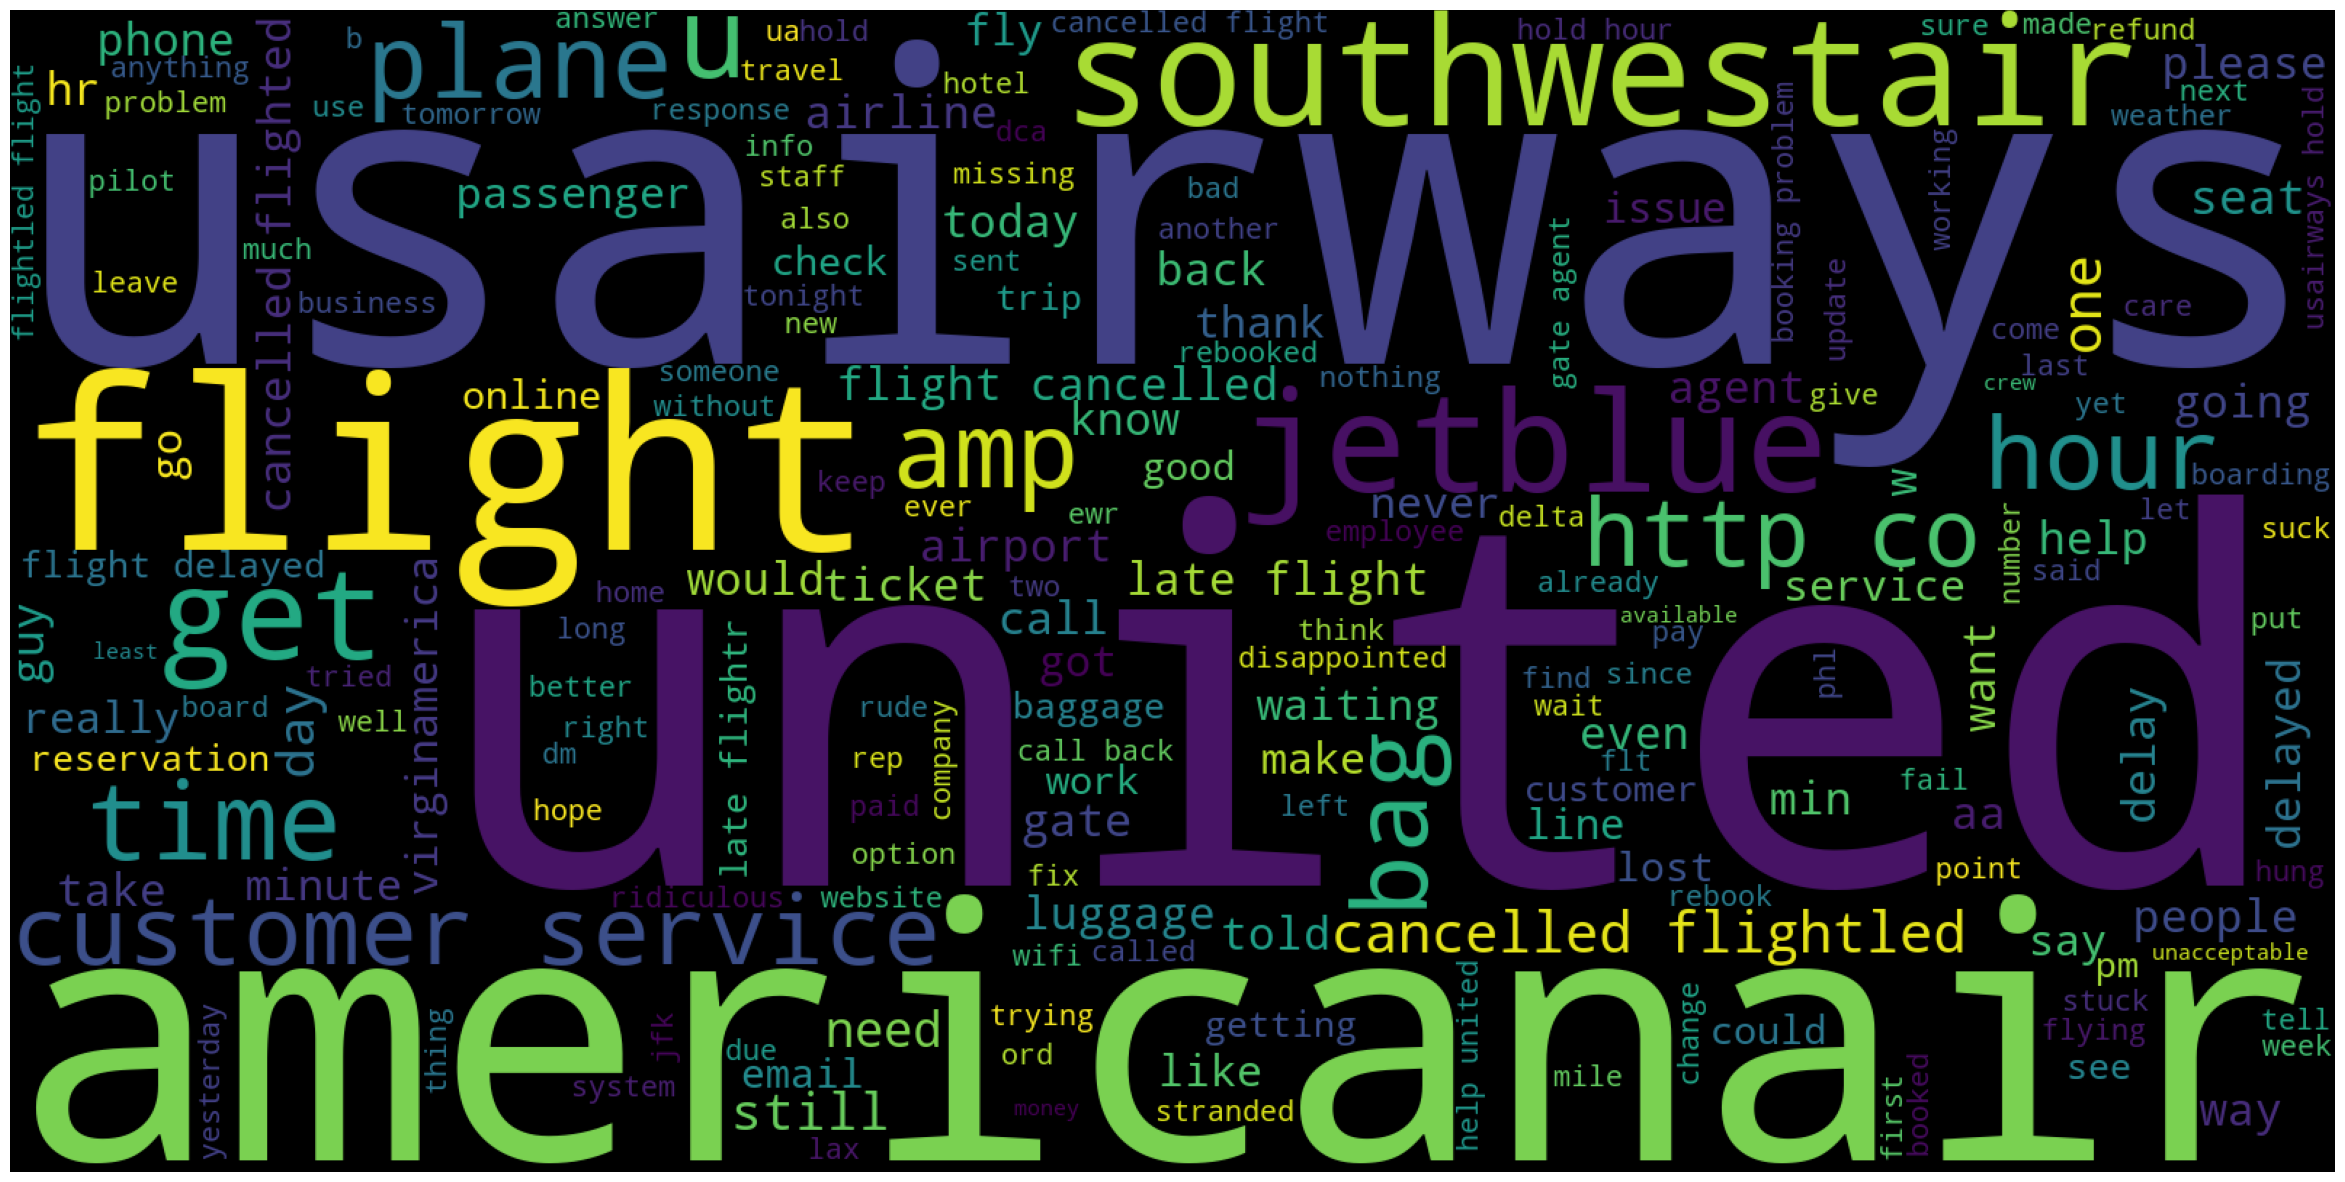

In [52]:
plt.figure(1,figsize=(30,20))
plt.imshow(Negative_wordcloud)
plt.axis('off')
plt.show()

## Converting Text to Numerical vectors - BOW Representation

In [53]:
train.head()

,airline_sentiment,airline,airline_sentiment_confidence,airline_sentiment_gold,name,negativereason,negativereason_confidence,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone,sentiment,clean_tweet_stem,clean_tweet_lemma
750,negative,United,1.0000,negative,bmalones44,Bad Flight,0.3451,Customer Service Issue,1,@united - 75% of a plane's passengers boarding...,"[0.0, 0.0]",2015-02-23 03:43:39 -0800,569824906638073856,P.R.O.B.,Quito,0,unit plane passeng board premier group might i...,united plane passenger boarding premier group ...
6875,negative,US Airways,1.0000,negative,Twinscream1,Customer Service Issue,1.0000,Customer Service Issue,0,@USAirways I have sent letter after letter and...,"[0.0, 0.0]",2015-02-18 11:18:40 -0800,568127477555441664,"Washington, DC",Eastern Time (US & Canada),0,usairway sent letter letter get back noth form...,usairways sent letter letter get back nothing ...
7598,negative,American,1.0000,negative,danilo23donna,longlines,0.3598,Customer Service Issue,0,@AmericanAir its not weather thats why i said ...,"[0.0, 0.0]",2015-02-23 23:55:21 -0800,570129843594997760,"Washington, DC",Eastern Time (US & Canada),0,americanair weather that said peopl receiv hot...,americanair weather thats said people received...
14124,positive,US Airways,0.3502,positive,MattClement,None,0.0000,None,0,@USAirways Oh well. I'll get to Cancun eventua...,"[0.0, 0.0]",2015-02-21 19:05:57 -0800,569332237138841600,"Troy, NY",Eastern Time (US & Canada),1,usairway oh well get cancun eventu,usairways oh well get cancun eventually
6187,negative,US Airways,1.0000,negative,POnions,Customer Service Issue,0.3683,Customer Service Issue,0,@USAirways looking forward to waiting on hold ...,"[0.0, 0.0]",2015-02-21 13:09:04 -0800,569242425530712064,"CT, USA",Central Time (US & Canada),0,usairway look forward wait hold hr reschedul f...,usairways looking forward waiting hold hr resc...


In [54]:
vocab = CountVectorizer()

train_bow = vocab.fit_transform(train['clean_tweet_lemma'])

In [55]:
train_bow

<11712x11131 sparse matrix of type '<class 'numpy.int64'>'
	with 113343 stored elements in Compressed Sparse Row format>

In [56]:
vocab.vocabulary_

{'united': 10130,
 'plane': 7256,
 'passenger': 7051,
 'boarding': 1047,
 'premier': 7438,
 'group': 4077,
 'might': 6083,
 'indication': 4727,
 'broken': 1183,
 'process': 7511,
 'usairways': 10255,
 'sent': 8577,
 'letter': 5501,
 'get': 3865,
 'back': 729,
 'nothing': 6624,
 'form': 3626,
 'half': 4149,
 'baked': 772,
 'reply': 8028,
 'usairwaysssuck': 10260,
 'americanair': 329,
 'weather': 10577,
 'thats': 9574,
 'said': 8373,
 'people': 7129,
 'received': 7842,
 'hotel': 4450,
 'room': 8269,
 'end': 3000,
 'line': 5563,
 'oh': 6764,
 'well': 10602,
 'cancun': 1350,
 'eventually': 3148,
 'looking': 5678,
 'forward': 3641,
 'waiting': 10491,
 'hold': 4372,
 'hr': 4481,
 'reschedule': 8055,
 'flight': 3497,
 'bunch': 1245,
 'idiot': 4575,
 'work': 10784,
 'airline': 215,
 'one': 6802,
 'checked': 1555,
 'bag': 755,
 'edinburgh': 2882,
 'however': 4470,
 'charged': 1524,
 'randomly': 7760,
 'dc': 2271,
 'newark': 6461,
 'southwestair': 8975,
 'thank': 9555,
 'much': 6296,
 'access': 

In [57]:
print("Total unique words:", len(vocab.vocabulary_))

print("Type of train features:", type(train_bow))

print("Shape of input data:", train_bow.shape)

Total unique words: 11131
Type of train features: <class 'scipy.sparse._csr.csr_matrix'>
Shape of input data: (11712, 11131)


In [58]:
test.head()

,airline_sentiment,airline,airline_sentiment_confidence,airline_sentiment_gold,name,negativereason,negativereason_confidence,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone,sentiment,clean_tweet_stem,clean_tweet_lemma
4794,negative,Delta,0.6559,negative,carloscrazyself,Flight Booking Problems,0.3333,Customer Service Issue,0,@JetBlue I'm trying to add my 2012 flights to ...,"[0.0, 0.0]",2015-02-18 13:14:41 -0800,568156672365092864,Atlantic City,Eastern Time (US & Canada),0,jetblu tri add flight badg account see option ...,jetblue trying add flight badge account see op...
10480,neutral,Southwest,1.0000,neutral,ohrebeca,None,0.0000,None,0,@SouthwestAir are there any flights from MSP t...,"[0.0, 0.0]",2015-02-19 09:11:16 -0800,568457802059902976,"minneapolis, mn",Central Time (US & Canada),1,southwestair flight msp hrl march look,southwestair flight msp hrl march looking
8067,negative,American,1.0000,negative,slippysam,Flight Attendant Complaints,1.0000,Customer Service Issue,0,@AmericanAir back in UK now no thanks to your ...,"[52.51012533, -2.98099904]",2015-02-23 09:48:02 -0800,569916606064828416,lydham shropshire uk,London,0,americanair back uk thank staff passeng strand...,americanair back uk thanks staff passenger str...
8880,negative,American,1.0000,negative,bfriend10,Can't Tell,0.6626,Customer Service Issue,0,@AmericanAir ...is this how you want to treat ...,"[0.0, 0.0]",2015-02-22 15:46:45 -0800,569644495517589504,Chicago,Eastern Time (US & Canada),0,americanair want treat platinum two gold flyer,americanair want treat platinum two gold flyer
8292,negative,American,1.0000,negative,Rom55Weber,Lost Luggage,1.0000,Customer Service Issue,0,"@AmericanAir I am, called Paris office this mo...","[0.0, 0.0]",2015-02-23 05:23:41 -0800,569850083140882432,"Washington, DC",Paris,0,americanair call pari offic morn still wait mi...,americanair called paris office morning still ...


In [59]:
test_bow = vocab.transform(test['clean_tweet_lemma'])

### Model Building and Evaluation

In [60]:
Classifiers = [
    LogisticRegression(),
    MultinomialNB(),
    KNeighborsClassifier(),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=200)
]

In [61]:
for classifier in Classifiers:
    model = classifier.fit(train_bow,train['sentiment'])
    pred = model.predict(test_bow)
    print("*"*10+classifier.__class__.__name__+"*"*10)
    accuracy = accuracy_score(pred,test['sentiment'])
    print('Accuracy : ', (accuracy))
    F1_Score = metrics.f1_score(pred,test['sentiment'], pos_label=1)
    print('F1 Score :', (F1_Score))
    print('Classification Report :')
    print(classification_report(pred,test['sentiment']))
    print()

**********LogisticRegression**********
Accuracy :  0.8247950819672131
F1 Score : 0.7603923400280242
Classification Report :
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      1848
           1       0.77      0.75      0.76      1080

    accuracy                           0.82      2928
   macro avg       0.81      0.81      0.81      2928
weighted avg       0.82      0.82      0.82      2928


**********MultinomialNB**********
Accuracy :  0.8155737704918032
F1 Score : 0.7154899894625921
Classification Report :
              precision    recall  f1-score   support

           0       0.92      0.82      0.86      2091
           1       0.64      0.81      0.72       837

    accuracy                           0.82      2928
   macro avg       0.78      0.81      0.79      2928
weighted avg       0.84      0.82      0.82      2928


**********KNeighborsClassifier**********
Accuracy :  0.5918715846994536
F1 Score : 0.6062602965403624

### Saving the Model and Vectorizer in Pickle

In [62]:
model = LogisticRegression()

model.fit(train_bow,train['sentiment'])

LogisticRegression()

In [63]:
from pickle import dump

dump(vocab, open('pickle/countvectorizer.pkl', 'wb'))

dump(model, open('pickle/logit_model.pkl', 'wb'))

### Prediction on Future Data Points

In [64]:
from pickle import load
import re

In [65]:
def preprocess(raw_tweet):
    # Removing special characters and digits
    letters_only = re.sub("[^a-zA-Z]", " ",raw_tweet)
    
    # change sentence to lower case
    letters_only = letters_only.lower()

    # tokenize into words
    words = letters_only.split()
    
    # remove stop words                
    words = [w for w in words if not w in stopwords.words("english")]
    
    # Stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    
    clean_sent = " ".join(words)
    
    return clean_sent

In [66]:
def predict(tweet):
    
    # Loading pretrained CountVectorizer from pickle file
    vectorizer = load(open('pickle/countvectorizer.pkl', 'rb'))
    
    # Loading pretrained logistic classifier from pickle file
    classifier = load(open('pickle/logit_model.pkl', 'rb'))
    
    # Preprocessing the tweet
    clean_tweet = preprocess(tweet)
    
    # Converting text to numerical vector
    clean_tweet_encoded = vectorizer.transform([clean_tweet])
    
    # Prediction
    prediction = classifier.predict(clean_tweet_encoded)
    
    return prediction

In [67]:
tweet = input("Enter a tweet to check its sentiment: ")

prediction = predict(tweet)

print(prediction)

Enter a tweet to check its sentiment: worst treatment
[0]


In [68]:
if(prediction == 0):
    print("Negative Sentiment")
else:
    print("Positive Sentiment")

Negative Sentiment


In [69]:
tweet1 = input("Enter a tweet to check its sentiment: ")

prediction = predict(tweet1)

print(prediction)

Enter a tweet to check its sentiment: great journey with best airlines
[1]


In [70]:
if(prediction == 0):
    print("Negative Sentiment")
else:
    print("Positive Sentiment")

Positive Sentiment
